In [ ]:

from utils.images_utils import decode_train_image,  get_image_path
import src.models.eval_metric.evaluate_metric as eval_metric
from tensorflow.keras.applications.resnet50 import ResNet50 
from tensorflow.keras.layers import  Concatenate, Multiply
from src.models.loss import WeightLossBinaryCrossentropy
from tensorflow.keras.initializers import RandomUniform
from tensorflow.keras.layers import  BatchNormalization
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Embedding, Dense
from tensorflow.keras.utils import plot_model
from config.config import CONFIGURATION_PATH
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Flatten 
from tensorflow.keras.metrics import Mean
import utils.write_utils as hlpwrite
import utils.read_utils as hlpread
from tensorflow.keras import Input
from datetime import timedelta
import tensorflow as tf
import pandas as pd 
import numpy as np 
import os
import gc
#import cudf 


: 

In [ ]:
##Delete this cell later
import src.models.eval_metric.evaluate_metric as eval_metric
from config.config import CONFIGURATION_PATH
import utils.write_utils as hlpwrite
import utils.read_utils as hlpread
import os
import gc

### Init Paths ###

In [2]:
current_dir = os.path.dirname(os.path.realpath('__file__'))
PROJECT_ROOT = os.path.abspath(os.path.join(current_dir, os.pardir))

while os.path.exists(os.path.join(PROJECT_ROOT, CONFIGURATION_PATH)) == False:    
    PROJECT_ROOT = os.path.abspath(os.path.join(PROJECT_ROOT, os.pardir))

#PROJECT_ROOT

In [3]:
TRAIN_DATA = os.path.join(
                         PROJECT_ROOT,
                         hlpread.read_yaml_key(os.path.join(PROJECT_ROOT, CONFIGURATION_PATH),'data_source','data_folders'),
                         hlpread.read_yaml_key(os.path.join(PROJECT_ROOT, CONFIGURATION_PATH),'data_source','processed_data_folder'),
                         hlpread.read_yaml_key(os.path.join(PROJECT_ROOT, CONFIGURATION_PATH),'data_source','training_data'),
                         )

TEST_DATA = os.path.join(PROJECT_ROOT, 
                         hlpread.read_yaml_key(os.path.join(PROJECT_ROOT, CONFIGURATION_PATH),'data_source','data_folders'),
                         hlpread.read_yaml_key(os.path.join(PROJECT_ROOT, CONFIGURATION_PATH),'data_source','processed_data_folder'),
                         hlpread.read_yaml_key(os.path.join(PROJECT_ROOT, CONFIGURATION_PATH),'data_source','testing_data'),
                         )

IMAGE_DATA = os.path.join(PROJECT_ROOT, 
                         hlpread.read_yaml_key(os.path.join(PROJECT_ROOT, CONFIGURATION_PATH),'data_source','data_folders'),
                         hlpread.read_yaml_key(os.path.join(PROJECT_ROOT, CONFIGURATION_PATH),'data_source','raw_data_folder'),
                         hlpread.read_yaml_key(os.path.join(PROJECT_ROOT, CONFIGURATION_PATH),'data_source','image_data'),
                         )

ARTICLE_TO_ITEM_ID_MAPPING = os.path.join(PROJECT_ROOT, 
                                        hlpread.read_yaml_key(os.path.join(PROJECT_ROOT, CONFIGURATION_PATH),'data_source','data_folders'),
                                        hlpread.read_yaml_key(os.path.join(PROJECT_ROOT, CONFIGURATION_PATH),'data_source','processed_data_folder'),
                                        hlpread.read_yaml_key(os.path.join(PROJECT_ROOT, CONFIGURATION_PATH),'data_source','article_item_mapping_data'),
                                        )

CUSTOMER_TO_USER_ID_MAPPING = os.path.join(PROJECT_ROOT, 
                                        hlpread.read_yaml_key(os.path.join(PROJECT_ROOT, CONFIGURATION_PATH),'data_source','data_folders'),
                                        hlpread.read_yaml_key(os.path.join(PROJECT_ROOT, CONFIGURATION_PATH),'data_source','processed_data_folder'),
                                        hlpread.read_yaml_key(os.path.join(PROJECT_ROOT, CONFIGURATION_PATH),'data_source','customer_user_mapping_data'),
                                        )

In [3]:
BASE_PATH =  os.path.join(PROJECT_ROOT,
                         hlpread.read_yaml_key(os.path.join(PROJECT_ROOT, CONFIGURATION_PATH),'model', 'output_folder'),
                         hlpread.read_yaml_key(os.path.join(PROJECT_ROOT, CONFIGURATION_PATH),'image-based-ensemble-models', 'models-ensemble-outputs-folder')
                        )


SAVED_TRAINING_MODEL = os.path.join(
                        BASE_PATH,
                        hlpread.read_yaml_key(os.path.join(PROJECT_ROOT, CONFIGURATION_PATH),'image-based-ensemble-models', 'saved_training_model')
                        )

TRAINING_MODEL_LOSS = os.path.join(
                        BASE_PATH,
                        hlpread.read_yaml_key(os.path.join(PROJECT_ROOT, CONFIGURATION_PATH),'image-based-ensemble-models', 'training_model_loss')
                        )

END_OF_TRAINING_LOSS = os.path.join(
                        BASE_PATH,
                        hlpread.read_yaml_key(os.path.join(PROJECT_ROOT, CONFIGURATION_PATH),'image-based-ensemble-models', 'end_of_training_loss')
                        )

ENSEMBLE_Y_PREDIT = os.path.join(
                        BASE_PATH,
                        hlpread.read_yaml_key(os.path.join(PROJECT_ROOT, CONFIGURATION_PATH),'image-based-ensemble-models', 'ensemble_folder'),
                        "image_based_train_y_predict.pkl"
                        )

ENSEMBLE_PR_RC_CURVE = os.path.join(
                        BASE_PATH,
                        hlpread.read_yaml_key(os.path.join(PROJECT_ROOT, CONFIGURATION_PATH),'image-based-ensemble-models', 'ensemble_folder'),
                        "pr_rc_curve_df.pkl"
                        )

ENSEMBLE_RC_CURVE = os.path.join(
                        BASE_PATH,
                        hlpread.read_yaml_key(os.path.join(PROJECT_ROOT, CONFIGURATION_PATH),'image-based-ensemble-models', 'ensemble_folder'),
                        "rc_curve_df.pkl"
                        )
                        
IMG_REC_MODEL = hlpread.read_yaml_key(os.path.join(PROJECT_ROOT, CONFIGURATION_PATH),'image-based-ensemble-models', 'saved_model')

TRAINING_STEP_LOSS = 'cp-epoch:{epoch:d}-step-loss.npz'
EPOCH_LOSS = 'cp-epoch-loss.npz'

IMG_REC_SAVED_MODEL = os.path.join(BASE_PATH , IMG_REC_MODEL)

NUMBER_ENSEMBLE = hlpread.read_yaml_key(os.path.join(PROJECT_ROOT, CONFIGURATION_PATH),'image-based-ensemble-models', 'number_ensemble_models')

is_pretrain_model_avail = os.path.exists(IMG_REC_SAVED_MODEL)

is_pretrain_model_avail

False

### Load data ###

In [10]:
#***************************** Load Train data ************************* 
print(f'Training data load...{TRAIN_DATA}')

train_tran = hlpread.read_from_parquet(TRAIN_DATA)

#Use last 4Week of data
last_tran_date_record = train_tran.t_dat.max()
split_t_dat = (last_tran_date_record - timedelta(weeks = 4))
train_tran = train_tran[(train_tran.t_dat <= split_t_dat)]

#train_tran = cudf.from_pandas(train_tran)

#Drop duplicate item specially for -ve sample since it is possible same item is taged as -ve for seperate days in case of negative sample.
#We shal keep the last -ve sample by t_dat
train_tran.drop_duplicates(subset = ['customer_id','article_id','label'], keep = 'last', inplace = True)

train_tran['label'] = train_tran['label'].astype(np.int32)

train_tran['image_path'] = list(map(get_image_path, train_tran['article_id']))


Training data load...F:\github_workspace\recommendation\data\processed\train_8Week_pos_neg_sample_data.parquet


In [11]:
#Map customer_id and article id with there unique id
item_to_article_id_mapping = hlpread.read_from_parquet(ARTICLE_TO_ITEM_ID_MAPPING)
user_to_customer_id_mapping = hlpread.read_from_parquet(CUSTOMER_TO_USER_ID_MAPPING)

train_tran = train_tran.merge(item_to_article_id_mapping, on = ['article_id'], how = 'inner')
train_tran = train_tran.merge(user_to_customer_id_mapping, on = ['customer_id'], how = 'inner')


NUM_UNIQUE_ITEMS = len(item_to_article_id_mapping.keys())
NUM_UNIQUE_USERS = train_tran.user_id.nunique() #len(user_to_customer_id_mapping.keys())


del [item_to_article_id_mapping, user_to_customer_id_mapping]
gc.collect()

1021

In [12]:
#Drop items having missing items

df_article = hlpread.read_from_parquet(
                                       os.path.join( 
                                             PROJECT_ROOT,
                                             hlpread.read_yaml_key(os.path.join(PROJECT_ROOT, CONFIGURATION_PATH),'data_source','data_folders'),
                                             hlpread.read_yaml_key(os.path.join(PROJECT_ROOT, CONFIGURATION_PATH),'data_source','processed_data_folder'), 
                                             hlpread.read_yaml_key(os.path.join(PROJECT_ROOT, CONFIGURATION_PATH),'data_source','clean_article_data'),
                                          )
                                      )

train_tran = train_tran.merge(df_article[['article_id', 'is_item_image_missing']], on = ['article_id'], how='inner')

train_tran = train_tran[~train_tran.is_item_image_missing]

del [df_article]
gc.collect()

0

### Define Model ###

In [30]:
EMBEDDING_U = 100
EMBEDDING_I = 100 
EMBEDDING_IMG = 200
INTER_EMBEDDING_I = 50 
FINE_TUNE_LAYERS = 15
TOTAL_TRAINABLE_LAYERS = 176
NUMBER_NON_TRAINABLE_LAYERS = TOTAL_TRAINABLE_LAYERS - FINE_TUNE_LAYERS

L2_reg = 0.05
LEARNING_RATE = 0.01 
num_replicas_in_sync = 8 #TPU
LEARNING_RATE = LEARNING_RATE * num_replicas_in_sync
GLOBAL_BATCH_SIZE  = 2048  
EPOCHS = 5

IMAGE_SIZES = 244  
CHANNEL = 3

Batch size: 2048


In [ ]:
#***************************** Optimizer, Loss Function and Metric *************************

init_lr = LEARNING_RATE 

print(f"Learning rate(lr): {init_lr}")
params = {}

params['alpha'] = 0.8 
params['num_replicas_in_sync'] = num_replicas_in_sync
params['global_batch_size'] = GLOBAL_BATCH_SIZE
params['from_logits'] = True

fn_loss = WeightLossBinaryCrossentropy(param = params)

fn_optimizer = Adam(learning_rate = init_lr) 

In [ ]:
if is_pretrain_model_avail == True:

    Img_Rec = load_model(IMG_REC_SAVED_MODEL, 
                            custom_objects = {'WeightLossBinaryCrossentropy': fn_loss}
                        )
    print(f"Loaded pre-trained mode from path {IMG_REC_SAVED_MODEL}")        


else:

    weight_initializers = RandomUniform(minval = -1, maxval = 1, seed = SEED)

    #***************************** User Embedding ************************* 
    User_Input = Input(shape = (1,), name = 'User_Input')  

    
    User_Embed = Embedding(input_dim = NUM_UNIQUE_USERS, 
                            input_length = 1,
                            output_dim = EMBEDDING_U,
                            embeddings_initializer = weight_initializers,
                            name = 'User_Embed'
                            )(User_Input)
    
    User_Embed_Batch_Normalize = BatchNormalization(name = 'User_Embed_Batch_Normalize')(User_Embed) 
    user_embedding = Flatten(name = "user_embedding")(User_Embed_Batch_Normalize) 
    

    #***************************** Image Embedding ************************* 
    Image_Input = Input(shape = ((IMAGE_SIZES, IMAGE_SIZES, CHANNEL)), name = 'Image_Input')
    model_RESENT50 = ResNet50(weights = 'imagenet', include_top = False, 
                                pooling = 'avg',
                                input_shape = (IMAGE_SIZES, IMAGE_SIZES, CHANNEL)
                                )
    model_RESENT50.trainable = True  
    number_of_layers = len(model_RESENT50.layers)
    print('Number of layers: ', number_of_layers)

    # Freeze all the layers before the `fine_tune_at` layer
    for layer in range(0, NUMBER_NON_TRAINABLE_LAYERS):
        model_RESENT50.layers[layer].trainable =  False

    non_trainable_layers_cnt = 0
    trainable_layers_cnt = 0

    for layer in range(0,len(model_RESENT50.layers)):

        if model_RESENT50.layers[layer].trainable == True:
            trainable_layers_cnt += 1

        elif model_RESENT50.layers[layer].trainable == False:
            non_trainable_layers_cnt += 1

    print('Number of non trainable layers in ResNet.....', non_trainable_layers_cnt) 
    print('Number of trainable layers in ResNet.....', trainable_layers_cnt)


    Image_RESNET_Output = model_RESENT50(Image_Input)
    
    Image_Embed_Dense = Dense(units = EMBEDDING_IMG,
                                activation = 'relu',
                                kernel_regularizer = l2(L2_reg), 
                                kernel_initializer = weight_initializers,
                                name = 'Image_Embed_Dense')(Image_RESNET_Output)
    Image_Embed  = BatchNormalization(name = 'image_embedding')(Image_Embed_Dense) 


    #***************************** Item embedding *************************

    Item_Input = Input(shape = (1,), name = 'Item_Input')
    
    Item_Embed = Embedding(input_dim = NUM_UNIQUE_ITEMS,
                            input_length = 1,
                            output_dim = INTER_EMBEDDING_I, 
                            embeddings_initializer = weight_initializers,
                            name = "Item_Embed"
                            )(Item_Input)
    
    Item_Embed_Batch_Normalize = BatchNormalization(name = 'Item_Embed_Batch_Normalize')(Item_Embed)
    Item_Embed_ReShape = Flatten(name = 'Item_Embed_Reshape')(Item_Embed_Batch_Normalize)
    
    Item_Image_Embedding = Concatenate(axis = 1, name = 'Item_Image_Concate')([Item_Embed_ReShape, Image_Embed])
    Item_Image_Embed_Dense = Dense(units = EMBEDDING_I, 
                                    activation = 'relu',
                                    kernel_regularizer = l2(L2_reg), 
                                    kernel_initializer = weight_initializers,
                                    name = 'Item_Image_Embed_Dense')(Item_Image_Embedding) 
    item_embedding = BatchNormalization(name = 'item_embedding')(Item_Image_Embed_Dense)


    #***************************** Model *************************
    dot_user_item = Multiply(name = 'mul_user_item')([user_embedding, item_embedding])
    logits = tf.math.reduce_sum(dot_user_item, 1, name = 'reduce_sum_logits')
    y_hat = logits

    Img_Rec = Model(inputs = [User_Input, Item_Input, Image_Input], outputs = [y_hat], name = 'Image_Recommendation')

Img_Rec.compile(optimizer = fn_optimizer, 
                loss = fn_loss
                )

In [ ]:
#plot_model(Img_Rec, show_shapes = True, to_file = "Image_based.png")

### Ensemble Different Resampled Datasets ###

We shall have 1:10 ration for ensemble model i.e for each 1 +ve sample we shall have 10 -ve sample

In [19]:
%%time

def generate_data_for_nth_ensemble_model(ensemble_model_number, pos_neg_ratio):
    
    #Split -ve and +ve sample from dataset
    train_tran_pos = train_tran[train_tran.label == 1]
    #train_tran_pos.user_id.nunique()
    train_tran_neg = train_tran[train_tran.label == 0]

    #Count number of +ve sample we have for each user based on that we will get -ve sample for each user for a given ensemble_model_number
    train_tran_neg = (train_tran_neg.merge((train_tran_pos[['user_id','label']]
                                            .groupby('user_id')['label']
                                            .count()
                                            .reset_index(name = 'cnt')
                                           ), 
                                           on = 'user_id', 
                                           how = 'inner')
                      )
    train_tran_neg['total_neg_sample_per_ensemble'] = train_tran_neg['cnt'] * pos_neg_ratio

    #train_tran_neg.groupby('user_id').label.count()

    total_neg_sample_per_ensemble = len(train_tran_pos) * pos_neg_ratio

    #Generate -ve sample based on the total +ve sample we have per user
    df_train_tran = pd.DataFrame()

    group_neg_user = train_tran_neg.groupby('user_id')
    ensemble_number = ensemble_model_number

    for i, x in enumerate(group_neg_user.groups):

        grp_key = group_neg_user.get_group(x)    

        total_neg_sample_per_user = grp_key.iloc[0,grp_key.columns.get_loc("total_neg_sample_per_ensemble")]

        data_start_index = ensemble_number * total_neg_sample_per_user
        data_end_index = data_start_index + total_neg_sample_per_user

        if i == 0:        
            df_train_tran = grp_key[['user_id','item_id','label','image_path']][data_start_index: data_end_index] #grp_key.nth(list(range(0, 10)))
        
        else:
            df_train_tran = pd.concat([df_train_tran, 
                                       (grp_key[['user_id','item_id','label','image_path']][data_start_index: data_end_index])],
                                      axis = 0)
    
    df_train_tran = pd.concat([train_tran_pos[['user_id','item_id','label','image_path']], df_train_tran], axis = 0)
    #df_train_tran = df_train_tran.sort_values(by = 'user_id')
    #Shuffle that will help for data pass for training
    df_train_tran = df_train_tran.sample(frac = 1).reset_index(drop = True)
    
    del [train_tran_pos, train_tran_neg]
    gc.collect()
    
    return df_train_tran

###########################################################################################################

CPU times: user 32.2 s, sys: 7.81 ms, total: 32.2 s
Wall time: 32.2 s


In [ ]:
gc.collect()

### Training ###

In [34]:
epoch_training_loss = []
epoch_loss_metric = Mean()
current_lr = init_lr


pos_neg_ratio = 10 
for ensemble in range(0, NUMBER_ENSEMBLE):

    print(f'Ensemble batch {ensemble}')

    df_train_tran = generate_data_for_nth_ensemble_model(ensemble, pos_neg_ratio)
  
    train_batch = (tf.data.Dataset
                .from_tensor_slices((df_train_tran['user_id'],
                                        df_train_tran['item_id'],
                                        df_train_tran['image_path'],
                                        df_train_tran['label']
                                    ))
                .map(decode_train_image, num_parallel_calls = tf.data.experimental.AUTOTUNE) 
                .prefetch(GLOBAL_BATCH_SIZE) 
                .batch(GLOBAL_BATCH_SIZE)                             
                )

    for epoch in range(0, EPOCHS):

        step_training_loss = []     
        epoch_loss_metric.reset_states()
        batch_cnt = 0        

        
        for  Users, Items, Image_Embeddings, Labels in train_batch:
    

            loss  = Img_Rec.train_on_batch(x = [Users, Items, Image_Embeddings], y = [Labels])
            epoch_loss_metric.update_state(loss)
            step_training_loss.append(loss)

            if batch_cnt % 10 == 0:
                template = ("Epoch {}, Batch {}, Current Batch Loss: {}, Average Loss: {}, Lr: {}")
                print(template.format(epoch + 1, 
                                    batch_cnt, 
                                    loss, 
                                    epoch_loss_metric.result().numpy(), 
                                    current_lr))
                
            batch_cnt += 1
            
            del [Users, Items, Image_Embeddings, Labels]
            gc.collect()       


        epoch_loss = float(epoch_loss_metric.result().numpy()) 
        epoch_training_loss.append(epoch_loss) 
        print('Average training losses over epoch done %d: %.4f' % (epoch, epoch_loss,)) 
        
        # Save training loss
        save_file_path = TRAINING_MODEL_LOSS + TRAINING_STEP_LOSS 
        save_file_path = save_file_path.format(epoch = epoch, ensemble = 0)   
        hlpwrite.save_compressed_numpy_array_data(save_file_path, step_training_loss)  

        print('='*50)
        print('\n')
        print('\n')
        gc.collect()
    
    # Save training loss per epoch
    save_file_path = END_OF_TRAINING_LOSS + EPOCH_LOSS
    save_file_path = save_file_path.format(ensemble = 0)  
    hlpwrite.save_compressed_numpy_array_data(save_file_path, epoch_training_loss) 
    

    # Save the ensemble model
    save_file_path = SAVED_TRAINING_MODEL + IMG_REC_MODEL
    save_file_path = save_file_path.format(epoch = epoch, ensemble = 0)   

    if not os.path.exists(os.path.dirname(save_file_path)):
        os.makedirs(os.path.dirname(save_file_path))

    Img_Rec.save(save_file_path)
    #Save to Json file will only save model architecture
    print(f"Saved model after end of epoch: {epoch}")

    del [train_batch]
    gc.collect()




Epoch 4, Batch 0, Current Batch Loss: 15.453357696533203, Average Loss: 15.453357696533203, Lr: 4e-06
Epoch 4, Batch 10, Current Batch Loss: 16.318470001220703, Average Loss: 16.582612991333008, Lr: 4e-06
Epoch 4, Batch 20, Current Batch Loss: 16.043224334716797, Average Loss: 16.71647071838379, Lr: 4e-06
Epoch 4, Batch 30, Current Batch Loss: 14.601068496704102, Average Loss: 16.687788009643555, Lr: 4e-06
Epoch 4, Batch 40, Current Batch Loss: 15.171343803405762, Average Loss: 16.714946746826172, Lr: 4e-06
Epoch 4, Batch 50, Current Batch Loss: 17.74945831298828, Average Loss: 16.721723556518555, Lr: 4e-06
Epoch 4, Batch 60, Current Batch Loss: 17.48895263671875, Average Loss: 16.786861419677734, Lr: 4e-06
Epoch 4, Batch 70, Current Batch Loss: 16.529048919677734, Average Loss: 16.824420928955078, Lr: 4e-06
Epoch 4, Batch 80, Current Batch Loss: 15.767623901367188, Average Loss: 16.75135612487793, Lr: 4e-06
Epoch 4, Batch 90, Current Batch Loss: 16.60028839111328, Average Loss: 16.751

2022-11-21 11:07:34.433135: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 139681, Output num: 2
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1669028854.431030335","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 139681, Output num: 2","grpc_status":3}


Average training losses over epoch done 3: 16.6234
LR at epoch 3 is :4e-06
Saved model after end of epoch: 3
Sucessfully created zip at path ./training_save_till_epoch_3.zip.
Training done. Final loss ... 16.623382568359375


### Evaluate metric for each ensemble model ###

#### Y_predict for each ensemble ####

In [ ]:
for ensemble in range(0, NUMBER_ENSEMBLE):

    print(f'Ensemble batch {ensemble}')

    df_train_tran = generate_data_for_nth_ensemble_model(ensemble, pos_neg_ratio)
  
    train_batch = (tf.data.Dataset
                .from_tensor_slices((df_train_tran['user_id'],
                                        df_train_tran['item_id'],
                                        df_train_tran['image_path'],
                                        df_train_tran['label']
                                    ))
                .map(decode_train_image, num_parallel_calls = tf.data.experimental.AUTOTUNE) 
                .prefetch(GLOBAL_BATCH_SIZE) 
                .batch(GLOBAL_BATCH_SIZE)                             
                )

    results = pd.DataFrame()
    
    for  Users, Items, Image_Embeddings, Labels in train_batch:

        score = Img_Rec.predict_on_batch([ Users,  Items,  Image_Embeddings])
        y_predict = tf.nn.sigmoid(score)
        dfparam = pd.DataFrame(
                                {
                                    'user_id': Users,
                                    'item_id': Items,
                                    'y_true': Labels,
                                    'y_pred' : y_predict,
                                    'score': score
                                }
                            )
        results = pd.concat([results, dfparam], axis = 0)
        
        if batch_cnt % 10 == 0:
            template = ("Batch {}")
            print(template.format(batch_cnt))
                
        batch_cnt += 1
        
        del [Users, Items, Image_Embeddings, Labels]
        gc.collect()

   
    save_file_path = ENSEMBLE_Y_PREDIT.format(ensemble = ensemble)  
    hlpwrite.save_to_pickle(results, save_file_path)
   

    #ROC Curve
    rc_curve_df = eval_metric.roc(results.y_true, results.y_pred)
    save_file_path = ENSEMBLE_RC_CURVE.format(ensemble = ensemble)
    hlpwrite.save_to_pickle(rc_curve_df, save_file_path)

    #PR-RC Curve
    pr_rc_curve_df = eval_metric.precision_recall(results.y_true, results.y_pred)
    save_file_path = ENSEMBLE_PR_RC_CURVE.format(ensemble = ensemble)
    hlpwrite.save_to_pickle(pr_rc_curve_df, save_file_path)

#### Plot PR-RC Curve for each ensemble ####

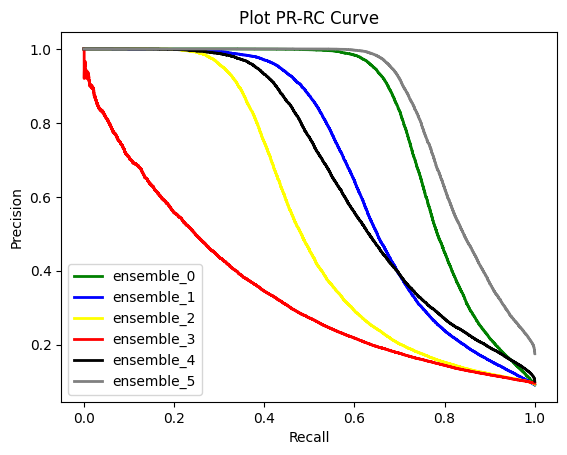

In [18]:
import matplotlib.pyplot as plt

markers = [".","o","1","3","*","p"]
colors = ['green', 'blue', 'yellow', 'red', 'black', 'gray']

for ensemble in range(0, 6):#NUMBER_ENSEMBLE
    file_path = ENSEMBLE_PR_RC_CURVE.format(ensemble = ensemble)
    df_ensemble = hlpread.read_from_pickle(file_path)

    plt.plot(df_ensemble['recall'], df_ensemble['precision'],  color = colors[ensemble], linewidth = 2, label = 'ensemble_'+str(ensemble)) #, marker = markers[ensemble]

    del [df_ensemble]
    gc.collect()
    
plt.legend()
plt.title('Plot PR-RC Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

**Observation:**

Ensemble model 2 and 3 perform worse.

#### Find right threshold of individual ensemble that give good precision and recall score ####

##### Ensemble 0 #####

In [55]:
ensemble = 0
file_path = ENSEMBLE_PR_RC_CURVE.format(ensemble = ensemble)
df_ensemble_0 = hlpread.read_from_pickle(file_path)
df_ensemble_0.head()

,precision,recall,thresholds,auc
0,0.091156,1.000000,0.000405,0.803361
1,0.091153,0.999964,0.000405,0.803361
2,0.091153,0.999964,0.000405,0.803361
3,0.091153,0.999964,0.000406,0.803361
4,0.091153,0.999964,0.000406,0.803361


In [63]:
df_ensemble_0[df_ensemble_0.thresholds >= 0.4]

,precision,recall,thresholds,auc
255277,0.934975,0.653845,0.400138,0.803361
255278,0.934972,0.653808,0.400141,0.803361
255279,0.934969,0.653772,0.400220,0.803361
255280,0.934965,0.653735,0.400253,0.803361
255281,0.935014,0.653735,0.400373,0.803361
...,...,...,...,...
270149,1.000000,0.027992,1.000000,0.803361
270150,1.000000,0.026897,1.000000,0.803361
270151,1.000000,0.023101,1.000000,0.803361
270152,1.000000,0.022189,1.000000,0.803361


In [70]:
threshold = 0.4

In [ ]:
file_path = ENSEMBLE_Y_PREDIT.format(ensemble = ensemble) 
df_y_predict_0 = hlpread.read_from_pickle(file_path)

In [71]:
eval_metric.report_classification(df_y_predict_0['y_true'], df_y_predict_0['y_pred'], threshold )

Classification report with threshold 0.4
              precision    recall  f1-score   support

           0       0.97      1.00      0.98    273910
           1       0.93      0.65      0.77     27401

    accuracy                           0.96    301311
   macro avg       0.95      0.82      0.88    301311
weighted avg       0.96      0.96      0.96    301311



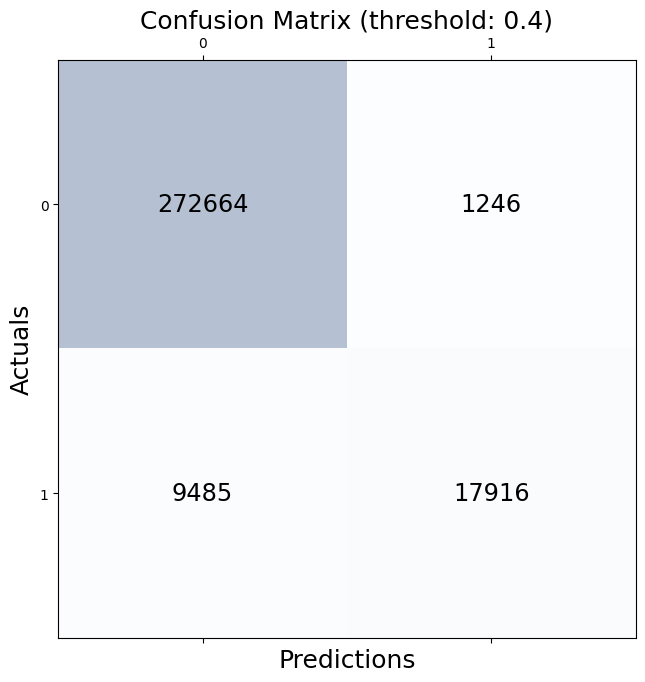

In [72]:
eval_metric.plot_confusion_matric(df_y_predict_0['y_true'], df_y_predict_0['y_pred'], threshold)

In [ ]:
del [df_ensemble_0, df_y_predict_0]
gc.collect()

##### Ensemble 1 #####

In [73]:
ensemble = 1
file_path = ENSEMBLE_PR_RC_CURVE.format(ensemble = ensemble)
df_ensemble_1 = hlpread.read_from_pickle(file_path)
df_ensemble_1.head()

,precision,recall,thresholds,auc
0,0.091425,1.000000,0.000011,0.680913
1,0.091422,0.999964,0.000011,0.680913
2,0.091422,0.999964,0.000012,0.680913
3,0.091422,0.999964,0.000013,0.680913
4,0.091423,0.999964,0.000019,0.680913


In [44]:
df_ensemble_1[df_ensemble_1.thresholds >= 0.4]

,precision,recall,thresholds,auc
265900,0.842414,0.518558,0.400022,0.680913
265901,0.842464,0.518558,0.400081,0.680913
265902,0.842455,0.518521,0.400133,0.680913
265903,0.842505,0.518521,0.400192,0.680913
265904,0.842495,0.518485,0.400194,0.680913
...,...,...,...,...
281662,1.000000,0.004562,1.000000,0.680913
281663,1.000000,0.004160,1.000000,0.680913
281664,1.000000,0.003321,1.000000,0.680913
281665,1.000000,0.003248,1.000000,0.680913


In [74]:
threshold = 0.4

In [75]:
file_path = ENSEMBLE_Y_PREDIT.format(ensemble = ensemble) 
df_y_predict_1 = hlpread.read_from_pickle(file_path)

In [76]:
eval_metric.report_classification(df_y_predict_1['y_true'], df_y_predict_1['y_pred'], threshold )

Classification report with threshold 0.4
              precision    recall  f1-score   support

           0       0.95      0.99      0.97    272321
           1       0.84      0.52      0.64     27401

    accuracy                           0.95    299722
   macro avg       0.90      0.75      0.81    299722
weighted avg       0.94      0.95      0.94    299722



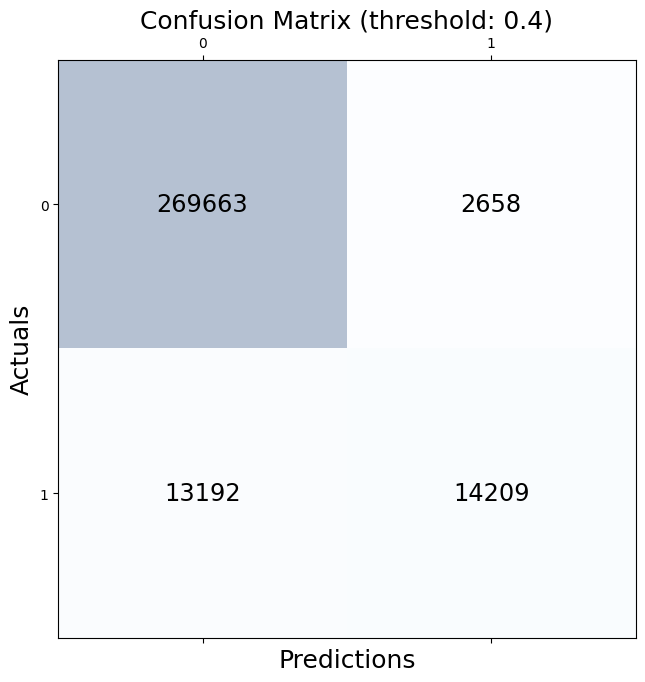

In [77]:
eval_metric.plot_confusion_matric(df_y_predict_1['y_true'], df_y_predict_1['y_pred'], threshold)

In [ ]:
del [df_ensemble_1, df_y_predict_1]
gc.collect()

##### Ensemble 2 #####

In [4]:
ensemble = 2
file_path = ENSEMBLE_PR_RC_CURVE.format(ensemble = ensemble)
df_ensemble_2 = hlpread.read_from_pickle(file_path)
df_ensemble_2.head()

,precision,recall,thresholds,auc
0,0.092803,1.000000,0.00002,0.548263
1,0.092800,0.999964,0.00002,0.548263
2,0.092800,0.999964,0.00002,0.548263
3,0.092801,0.999964,0.00002,0.548263
4,0.092801,0.999964,0.00002,0.548263


In [7]:
df_ensemble_2[df_ensemble_2.thresholds >= 0.4]

,precision,recall,thresholds,auc
237479,0.292656,0.599431,0.400019,0.548263
237480,0.292661,0.599431,0.400025,0.548263
237481,0.292666,0.599431,0.400046,0.548263
237482,0.292671,0.599431,0.400058,0.548263
237483,0.292676,0.599431,0.400069,0.548263
...,...,...,...,...
292380,1.000000,0.000584,1.000000,0.548263
292381,1.000000,0.000474,1.000000,0.548263
292382,1.000000,0.000438,1.000000,0.548263
292383,1.000000,0.000219,1.000000,0.548263


In [8]:
threshold = 0.4

In [9]:
file_path = ENSEMBLE_Y_PREDIT.format(ensemble = ensemble) 
df_y_predict_2 = hlpread.read_from_pickle(file_path)

In [12]:
eval_metric.report_classification(df_y_predict_2['y_true'], df_y_predict_2['y_pred'], threshold )

Classification report with threshold 0.4
              precision    recall  f1-score   support

           0       0.95      0.85      0.90    267959
           1       0.29      0.60      0.39     27401

    accuracy                           0.83    295360
   macro avg       0.62      0.73      0.65    295360
weighted avg       0.89      0.83      0.85    295360



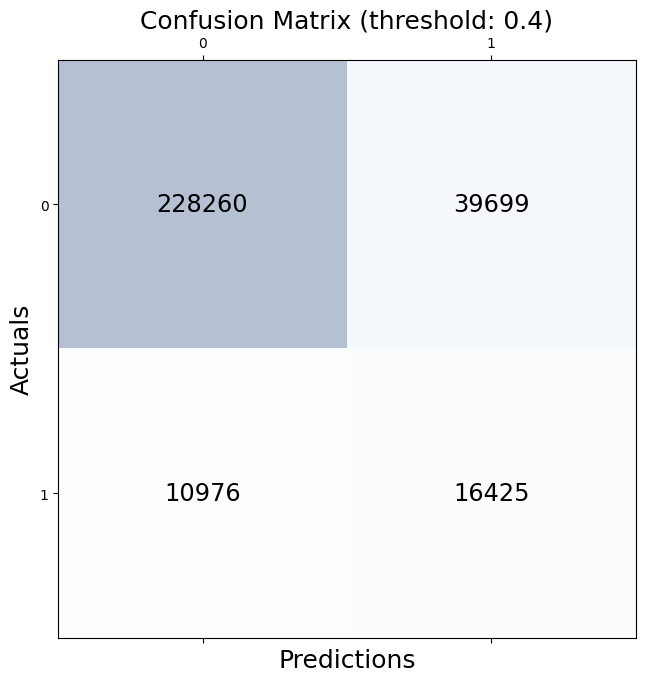

In [13]:
eval_metric.plot_confusion_matric(df_y_predict_2['y_true'], df_y_predict_2['y_pred'], threshold)

In [14]:
del [df_ensemble_2, df_y_predict_2]
gc.collect()

2609

##### Ensemble 3 #####

In [15]:
ensemble = 3
file_path = ENSEMBLE_PR_RC_CURVE.format(ensemble = ensemble)
df_ensemble_3 = hlpread.read_from_pickle(file_path)
df_ensemble_3.head()


,precision,recall,thresholds,auc
0,0.095690,1.000000,0.006058,0.348131
1,0.095686,0.999964,0.006098,0.348131
2,0.095687,0.999964,0.006544,0.348131
3,0.095687,0.999964,0.006630,0.348131
4,0.095687,0.999964,0.006746,0.348131


In [17]:

df_ensemble_3[df_ensemble_3.thresholds >= 0.1]


,precision,recall,thresholds,auc
160953,0.164997,0.732674,0.100000,0.348131
160954,0.164998,0.732674,0.100000,0.348131
160955,0.165000,0.732674,0.100001,0.348131
160956,0.165001,0.732674,0.100001,0.348131
160957,0.165002,0.732674,0.100002,0.348131
...,...,...,...,...
281167,1.000000,0.000182,0.943760,0.348131
281168,1.000000,0.000146,0.954170,0.348131
281169,1.000000,0.000109,0.961370,0.348131
281170,1.000000,0.000073,0.973018,0.348131


In [18]:
threshold = 0.1

In [19]:
file_path = ENSEMBLE_Y_PREDIT.format(ensemble = ensemble) 
df_y_predict_3 = hlpread.read_from_pickle(file_path)

In [20]:
eval_metric.report_classification(df_y_predict_3['y_true'], df_y_predict_3['y_pred'], threshold )

Classification report with threshold 0.1
              precision    recall  f1-score   support

           0       0.96      0.61      0.74    258963
           1       0.16      0.73      0.27     27401

    accuracy                           0.62    286364
   macro avg       0.56      0.67      0.51    286364
weighted avg       0.88      0.62      0.70    286364



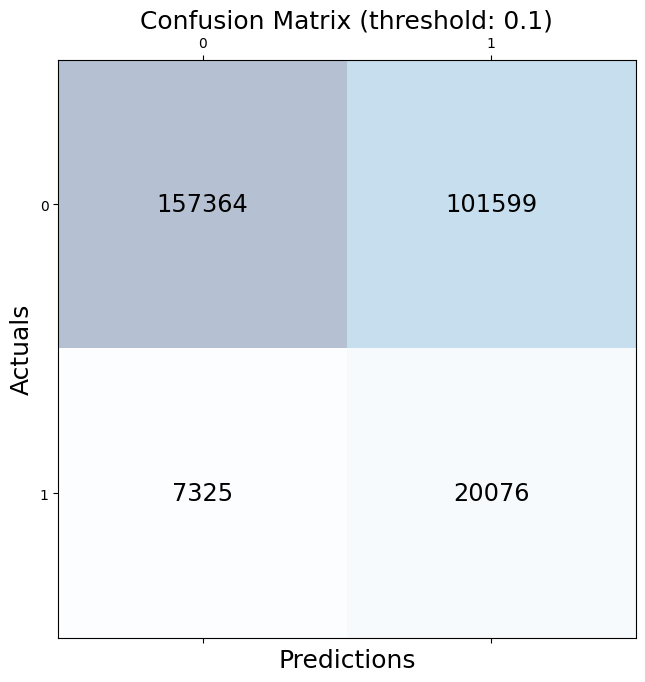

In [21]:
eval_metric.plot_confusion_matric(df_y_predict_3['y_true'], df_y_predict_3['y_pred'], threshold)

In [22]:
del [df_ensemble_3, df_y_predict_3]
gc.collect()

2615

##### Ensemble 4 #####

In [33]:
ensemble = 4
file_path = ENSEMBLE_PR_RC_CURVE.format(ensemble = ensemble)
df_ensemble_4 = hlpread.read_from_pickle(file_path)
df_ensemble_4.head()

,precision,recall,thresholds,auc
0,0.100616,1.000000,0.000112,0.665546
1,0.100613,0.999964,0.000112,0.665546
2,0.100613,0.999964,0.000112,0.665546
3,0.100614,0.999964,0.000112,0.665546
4,0.100614,0.999964,0.000112,0.665546


In [34]:
df_ensemble_4[df_ensemble_4.thresholds >= 0.30]

,precision,recall,thresholds,auc
240666,0.559361,0.599066,0.300004,0.665546
240667,0.559380,0.599066,0.300009,0.665546
240668,0.559399,0.599066,0.300020,0.665546
240669,0.559418,0.599066,0.300022,0.665546
240670,0.559437,0.599066,0.300061,0.665546
...,...,...,...,...
269788,1.000000,0.000182,0.999991,0.665546
269789,1.000000,0.000146,0.999992,0.665546
269790,1.000000,0.000109,0.999994,0.665546
269791,1.000000,0.000073,0.999996,0.665546


In [38]:
threshold = 0.35

In [36]:
file_path = ENSEMBLE_Y_PREDIT.format(ensemble = ensemble) 
df_y_predict_4 = hlpread.read_from_pickle(file_path)

In [39]:
eval_metric.report_classification(df_y_predict_4['y_true'], df_y_predict_4['y_pred'], threshold )

Classification report with threshold 0.35
              precision    recall  f1-score   support

           0       0.95      0.96      0.96    245994
           1       0.61      0.57      0.59     27401

    accuracy                           0.92    273395
   macro avg       0.78      0.77      0.77    273395
weighted avg       0.92      0.92      0.92    273395



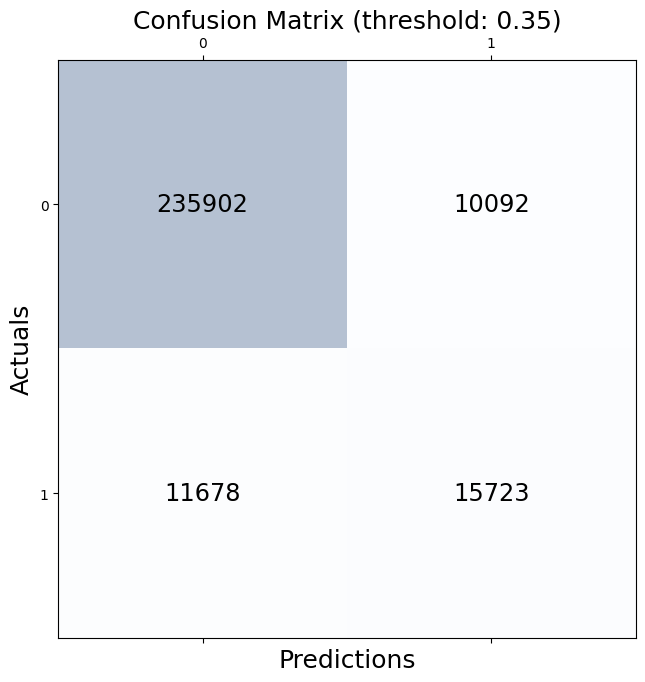

In [40]:
eval_metric.plot_confusion_matric(df_y_predict_4['y_true'], df_y_predict_4['y_pred'], threshold)

In [32]:
del [df_ensemble_4, df_y_predict_4]
gc.collect()

2615

##### Ensemble 5 #####

In [41]:
ensemble = 5
file_path = ENSEMBLE_PR_RC_CURVE.format(ensemble = ensemble)
df_ensemble_5 = hlpread.read_from_pickle(file_path)
df_ensemble_5.head()

,precision,recall,thresholds,auc
0,0.175292,1.000000,0.000004,0.851843
1,0.175287,0.999964,0.000004,0.851843
2,0.175288,0.999964,0.000004,0.851843
3,0.175289,0.999964,0.000004,0.851843
4,0.175290,0.999964,0.000004,0.851843


In [47]:
df_ensemble_5[df_ensemble_5.thresholds >= 0.4]

,precision,recall,thresholds,auc
133882,0.892087,0.711397,0.400063,0.851843
133883,0.892082,0.711361,0.400240,0.851843
133884,0.892123,0.711361,0.400299,0.851843
133885,0.892118,0.711324,0.400344,0.851843
133886,0.892159,0.711324,0.400359,0.851843
...,...,...,...,...
152358,1.000000,0.000292,0.999999,0.851843
152359,1.000000,0.000219,0.999999,0.851843
152360,1.000000,0.000182,0.999999,0.851843
152361,1.000000,0.000109,1.000000,0.851843


In [48]:
threshold = 0.4


In [49]:
file_path = ENSEMBLE_Y_PREDIT.format(ensemble = ensemble) 
df_y_predict_5 = hlpread.read_from_pickle(file_path)

In [50]:
eval_metric.report_classification(df_y_predict_5['y_true'], df_y_predict_5['y_pred'], threshold )

Classification report with threshold 0.4
              precision    recall  f1-score   support

           0       0.94      0.98      0.96    129632
           1       0.89      0.71      0.79     27401

    accuracy                           0.93    157033
   macro avg       0.92      0.85      0.88    157033
weighted avg       0.93      0.93      0.93    157033



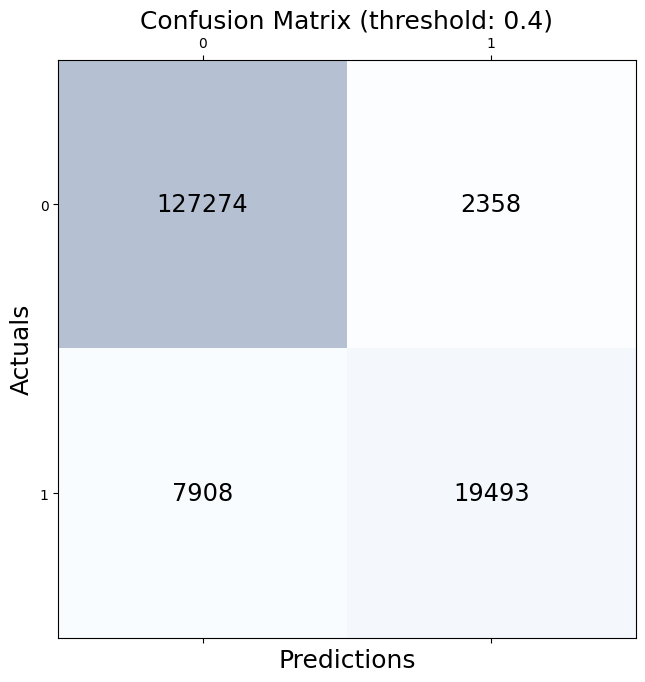

In [51]:
eval_metric.plot_confusion_matric(df_y_predict_5['y_true'], df_y_predict_5['y_pred'], threshold)

In [52]:
del [df_ensemble_5, df_y_predict_5]
gc.collect()

5209

### Predict on last 4 week train dataset ###

In [ ]:
import re

all_models = [] 

def load_all_image_based_resnet_models(n_models = -1 ):
    
    """
    load models of image based model that is trained on different set of negative sample 
    n_models: number of model to load. By default = -1 meanse all the model in the folder
    """

    models_paths = os.path.join( 
                                hlpread.read_yaml_key(CONFIGURATION_PATH, 'model', 'output_folder'),
                                hlpread.read_yaml_key(CONFIGURATION_PATH, 'image-based-ensemble-models', 'models-ensemble-outputs-folder')
                                )

    ensemble = 'ensemble_{ensemble:d}'
    ensemble_models_paths = os.path.join(  models_paths,
                                            ensemble,
                                            'Img_Rec_model.h5'
                                            #'Img_Rec_model.json'
                                        )  
    
    if n_models == -1:
        n_models = 0
        for entry in os.listdir(models_paths):
            if re.search('ensemble_', entry):
                n_models += 1    

    for i in range(n_models):

        model_path = ensemble_models_paths.format(ensemble = i)  
        if os.path.exists(model_path) == True:

            #self.all_models.append(model_from_json(read_object(model_path)))
            all_models.append(load_model(model_path, custom_objects = {'WeightLossBinaryCrossentropy': WeightLossBinaryCrossentropy}))
            #load_theshold_model(i)

In [ ]:
load_all_image_based_resnet_models()

In [ ]:
BATCH_SIZE_PER_REPLICA  = 1024 #64

if num_replicas_in_sync > 1:  
    GLOBAL_BATCH_SIZE = BATCH_SIZE_PER_REPLICA * num_replicas_in_sync
else:
    GLOBAL_BATCH_SIZE = BATCH_SIZE_PER_REPLICA

In [ ]:
AUTO = tf.data.experimental.AUTOTUNE
BUFFER_SIZE = len(train_tran)

train_batch = (tf.data.Dataset
               .from_tensor_slices((train_tran['user_id'],
                                    train_tran['item_id'],
                                    train_tran['image_path'],
                                    train_tran['label']
                                   ))              
               .map(decode_train_image, num_parallel_calls = AUTO) 
               #.with_options(options)
               #.shuffle(BUFFER_SIZE, seed = SEED)
               .prefetch(GLOBAL_BATCH_SIZE) 
               .batch(GLOBAL_BATCH_SIZE)                             
               )

In [ ]:
stackX = pd.DataFrame()
#batch_cnt = 0

for  Users, Items, Image_Embeddings, Y_True in train_batch:
    dfparam = pd.DataFrame(
                            {
                                'user_id': Users,
                                'item_id': Items,  
                                'Y_true': Y_True
                            }
                        )

    for i, model in enumerate(all_models):
        yhat = model.predict([Users, Items, Image_Embeddings])
        yhat = tf.nn.sigmoid(yhat)
        dfparam['y_hat_'+ str(i) ] = yhat
    
    stackX = pd.concat([stackX, dfparam], axis = 0)
    
    """
    if batch_cnt % 25 == 0:
        template = ("Batch {}")
        print(template.format(batch_cnt))
            
    batch_cnt += 1
    """

    del [Users, Items, Image_Embeddings, Y_True]
    gc.collect()

In [ ]:
stackX.to_parquet('training_y_predict.parquet')

### Predict on Test Data ###

In [ ]:
#***************************** Load Train data ************************* 
print(f'Testing data load...{TEST_DATA}')

test_data = hlpread.read_from_parquet(TEST_DATA)

test_data.drop_duplicates(subset = ['customer_id','article_id','label'], keep = 'last', inplace = True)
test_data['label'] = test_data['label'].astype(np.int32)

In [ ]:
#Map customer_id and article id with there unique id
item_to_article_id_mapping = hlpread.read_from_parquet(ARTICLE_TO_ITEM_ID_MAPPING)
user_to_customer_id_mapping = hlpread.read_from_parquet(CUSTOMER_TO_USER_ID_MAPPING)

test_data = test_data.merge(item_to_article_id_mapping, on = ['article_id'], how = 'inner')
test_data = test_data.merge(user_to_customer_id_mapping, on = ['customer_id'], how = 'inner')

del [item_to_article_id_mapping, user_to_customer_id_mapping]
gc.collect()

In [ ]:
#Drop items having missing items
df_article = hlpread.read_from_parquet(
                                       os.path.join( 
                                             PROJECT_ROOT,
                                             hlpread.read_yaml_key(os.path.join(PROJECT_ROOT, CONFIGURATION_PATH),'data_source','data_folders'),
                                             hlpread.read_yaml_key(os.path.join(PROJECT_ROOT, CONFIGURATION_PATH),'data_source','processed_data_folder'), 
                                             hlpread.read_yaml_key(os.path.join(PROJECT_ROOT, CONFIGURATION_PATH),'data_source','clean_article_data'),
                                          )
                                      )

test_data = test_data.merge(df_article[['article_id', 'is_item_image_missing']], on = ['article_id'], how='inner')
test_data = test_data[~test_data.is_item_image_missing]

del [df_article]
gc.collect()

In [ ]:
test_data['image_path'] = list(map(get_image_path, test_data['article_id']))

In [ ]:
load_all_image_based_resnet_models()

In [ ]:
BATCH_SIZE_PER_REPLICA  = 1024 #64

if num_replicas_in_sync > 1:  
    GLOBAL_BATCH_SIZE = BATCH_SIZE_PER_REPLICA * num_replicas_in_sync
else:
    GLOBAL_BATCH_SIZE = BATCH_SIZE_PER_REPLICA
    
AUTO = tf.data.experimental.AUTOTUNE
BUFFER_SIZE = len(train_tran)

test_batch = (tf.data.Dataset
               .from_tensor_slices((test_data['user_id'],
                                    test_data['item_id'],
                                    test_data['image_path'],
                                    test_data['label']
                                   ))              
               .map(decode_train_image, num_parallel_calls = AUTO) 
               #.with_optest_batchtions(options)
               #.shuffle(BUFFER_SIZE, seed = SEED)
               .prefetch(GLOBAL_BATCH_SIZE) 
               .batch(GLOBAL_BATCH_SIZE)                             
               )

In [ ]:
stackX = pd.DataFrame()
#batch_cnt = 0

for  Users, Items, Image_Embeddings, Y_True in test_batch:
    dfparam = pd.DataFrame(
                            {
                                'user_id': Users,
                                'item_id': Items,  
                                'Y_true': Y_True
                            }
                        )

    for i, model in enumerate(all_models):
        yhat = model.predict([Users, Items, Image_Embeddings])
        yhat = tf.nn.sigmoid(yhat)
        dfparam['y_hat_'+ str(i) ] = yhat
    
    stackX = pd.concat([stackX, dfparam], axis = 0)
    
    """
    if batch_cnt % 25 == 0:
        template = ("Batch {}")
        print(template.format(batch_cnt))
            
    batch_cnt += 1
    """
    
    del [Users, Items, Image_Embeddings, Y_True]
    gc.collect()

In [ ]:
stackX.to_parquet('test_y_predict.parquet')

## Evaluate metric ##

### Train ###

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import mode
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


In [ ]:
train = pd.read_parquet(r'C:\Users\smithau8\Desktop\30Dec\training_y_predict.parquet')

In [2]:
train.head()

,user_id,item_id,Y_true,y_hat_0,y_hat_1,y_hat_2,y_hat_3,y_hat_4,y_hat_5
0,24,96410,1,0.005260,0.967894,0.992871,0.476899,0.605526,0.878285
1,24,97001,0,0.017356,0.052616,0.341911,0.156105,0.398302,0.839750
2,24,83660,0,0.813099,0.220722,0.955699,0.193090,0.511494,0.821629
3,24,73806,0,0.016856,0.241507,0.936071,0.158996,0.501026,0.673656
4,24,73810,0,0.011686,0.042559,0.468165,0.146991,0.439111,0.707247


In [3]:
train['Y_predict_0'] = train.y_hat_0 >= 0.4
train['Y_predict_1'] = train.y_hat_1 >= 0.4
train['Y_predict_2'] = train.y_hat_2 >= 0.4
train['Y_predict_3'] = train.y_hat_3 >= 0.1
train['Y_predict_4'] = train.y_hat_4 >= 0.35
train['Y_predict_5'] = train.y_hat_5 >= 0.4

train.columns

Index(['user_id', 'item_id', 'Y_true', 'y_hat_0', 'y_hat_1', 'y_hat_2',
       'y_hat_3', 'y_hat_4', 'y_hat_5', 'Y_predict_0', 'Y_predict_1',
       'Y_predict_2', 'Y_predict_3', 'Y_predict_4', 'Y_predict_5'],
      dtype='object')

In [4]:
train[['Y_true','Y_predict_0', 'Y_predict_1', 'Y_predict_2', 'Y_predict_3', 'Y_predict_4', 'Y_predict_5']]

,Y_true,Y_predict_0,Y_predict_1,Y_predict_2,Y_predict_3,Y_predict_4,Y_predict_5
0,1,False,True,True,True,True,True
1,0,False,False,False,True,True,True
2,0,True,False,True,True,True,True
3,0,False,False,True,True,True,True
4,0,False,False,True,True,True,True
...,...,...,...,...,...,...,...
8187,0,True,False,False,True,False,True
8188,0,True,False,False,False,True,True
8189,0,True,False,False,False,True,True
8190,0,True,False,False,False,True,True


In [10]:

#'Y_predict_2', 'Y_predict_3',
train['Y_hat'] = np.squeeze( mode(train[['Y_predict_0', 'Y_predict_1', 'Y_predict_4', 'Y_predict_5']], axis = 1)[0])
train[['Y_true', 'Y_hat']]

,Y_true,Y_hat
0,1,True
1,0,False
2,0,True
3,0,False
4,0,False
...,...,...
8187,0,False
8188,0,True
8189,0,True
8190,0,True


In [14]:
train.Y_true.value_counts()

0    2098487
1      15049
Name: Y_true, dtype: int64

In [15]:
train.Y_hat.value_counts()

False    1341556
True      771980
Name: Y_hat, dtype: int64

In [16]:
print(classification_report(train.Y_true, train.Y_hat))

              precision    recall  f1-score   support

           0       0.99      0.63      0.77   2098487
           1       0.01      0.37      0.01     15049

    accuracy                           0.63   2113536
   macro avg       0.50      0.50      0.39   2113536
weighted avg       0.99      0.63      0.77   2113536



In [12]:

print(confusion_matrix(train.Y_true, train.Y_hat))

[[1332081  766406]
 [   9475    5574]]


### Test ###

In [17]:
test = pd.read_parquet(r'C:\Users\smithau8\Desktop\30Dec\test_y_predict.parquet')

In [18]:
#individual threshold based prediction to find the right label 
test['Y_predict_0'] = test.y_hat_0 >= 0.4
test['Y_predict_1'] = test.y_hat_1 >= 0.4
test['Y_predict_2'] = test.y_hat_2 >= 0.4
test['Y_predict_3'] = test.y_hat_3 >= 0.1
test['Y_predict_4'] = test.y_hat_4 >= 0.35
test['Y_predict_5'] = test.y_hat_5 >= 0.4

test.columns

Index(['user_id', 'item_id', 'Y_true', 'y_hat_0', 'y_hat_1', 'y_hat_2',
       'y_hat_3', 'y_hat_4', 'y_hat_5', 'Y_predict_0', 'Y_predict_1',
       'Y_predict_2', 'Y_predict_3', 'Y_predict_4', 'Y_predict_5'],
      dtype='object')

In [19]:
test[['Y_true','Y_predict_0', 'Y_predict_1', 'Y_predict_2', 'Y_predict_3', 'Y_predict_4', 'Y_predict_5']]

,Y_true,Y_predict_0,Y_predict_1,Y_predict_2,Y_predict_3,Y_predict_4,Y_predict_5
0,1,False,False,False,True,True,True
1,1,False,False,False,True,True,True
2,1,False,False,False,False,True,True
3,1,False,False,False,False,True,True
4,1,False,False,False,False,False,True
...,...,...,...,...,...,...,...
348,0,True,True,True,True,True,True
349,0,True,True,True,True,True,False
350,0,True,False,False,True,False,False
351,0,True,True,True,True,True,True


In [20]:
#'Y_predict_2', 'Y_predict_3',
test['Y_hat'] = np.squeeze( mode(test[['Y_predict_0', 'Y_predict_1', 'Y_predict_4', 'Y_predict_5']], axis = 1)[0])
test[['Y_true', 'Y_hat']]

,Y_true,Y_hat
0,1,False
1,1,False
2,1,False
3,1,False
4,1,False
...,...,...
348,0,True
349,0,True
350,0,False
351,0,True


In [21]:
test.Y_true.value_counts()

0    1078541
1      17492
Name: Y_true, dtype: int64

In [22]:
test.Y_hat.value_counts()

False    590210
True     505823
Name: Y_hat, dtype: int64

In [23]:
print(classification_report(test.Y_true, test.Y_hat))

              precision    recall  f1-score   support

           0       0.99      0.54      0.70   1078541
           1       0.02      0.51      0.03     17492

    accuracy                           0.54   1096033
   macro avg       0.50      0.53      0.37   1096033
weighted avg       0.97      0.54      0.69   1096033



In [24]:

print(confusion_matrix(test.Y_true, test.Y_hat))

[[581682 496859]
 [  8528   8964]]


##  Alternative method to merge the output of ensemble ## 

### Logistic Regression ###

In [27]:
train.columns

Index(['user_id', 'item_id', 'Y_true', 'y_hat_0', 'y_hat_1', 'y_hat_2',
       'y_hat_3', 'y_hat_4', 'y_hat_5', 'Y_predict_0', 'Y_predict_1',
       'Y_predict_2', 'Y_predict_3', 'Y_predict_4', 'Y_predict_5', 'Y_hat'],
      dtype='object')

In [29]:
train[['y_hat_0', 'y_hat_1', 'y_hat_2',
       'y_hat_3', 'y_hat_4', 'y_hat_5','Y_true']].corr()

,y_hat_0,y_hat_1,y_hat_2,y_hat_3,y_hat_4,y_hat_5,Y_true
y_hat_0,1.000000,0.532925,0.374040,0.036584,0.071181,-0.119087,-0.006028
y_hat_1,0.532925,1.000000,0.497392,0.145529,0.149337,-0.089903,0.001862
y_hat_2,0.374040,0.497392,1.000000,0.242906,0.331140,-0.079944,0.000238
y_hat_3,0.036584,0.145529,0.242906,1.000000,0.237952,0.091400,0.010017
y_hat_4,0.071181,0.149337,0.331140,0.237952,1.000000,0.093210,0.001771
y_hat_5,-0.119087,-0.089903,-0.079944,0.091400,0.093210,1.000000,0.011267
Y_true,-0.006028,0.001862,0.000238,0.010017,0.001771,0.011267,1.000000


### Decision Tree ###

In [1]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
import pandas as pd

In [2]:
train = pd.read_parquet(r'C:\Users\smithau8\Desktop\30Dec\training_y_predict.parquet')

In [3]:
train.columns

Index(['user_id', 'item_id', 'Y_true', 'y_hat_0', 'y_hat_1', 'y_hat_2',
       'y_hat_3', 'y_hat_4', 'y_hat_5'],
      dtype='object')

In [7]:
train.shape

(2929561, 9)

In [4]:
search_paramaters = {
                        "max_depth": [10,15,20,None],
                        "min_samples_split": [2,5,7,10],
                        "min_samples_leaf": [2,5,6,10]
                    }

SEED = 42

In [5]:
clf_DTree = DecisionTreeClassifier(random_state = SEED)
clf_random_search_cv = RandomizedSearchCV(clf_DTree, search_paramaters, random_state = SEED)

In [6]:
X_train = train[['y_hat_0', 'y_hat_1', 'y_hat_2','y_hat_3', 'y_hat_4', 'y_hat_5']]
Y_train = train[['Y_true']]

In [8]:
search_result = clf_random_search_cv.fit(X_train, Y_train)

Error: Canceled future for execute_request message before replies were done

In [ ]:
search_result.best_params_

In [ ]:
search_result.best_score_

In [ ]:
y_pred = search_result.predict(X_train)
y_true = Y_train

In [ ]:
from sklearn.metrics import classification_report


print(classification_report(y_true, y_pred))